In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import cv2
from PIL import Image

In [2]:
input_dir = pathlib.Path(r"data/soybean/")
label_names = sorted(item.name for item in input_dir.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
index_to_label = dict(zip(label_to_index.values(),label_to_index.keys()))
label_to_index

{'broadleaf': 0, 'grass': 1, 'soil': 2, 'soybean': 3}

In [3]:
images = list(input_dir.glob('*/*.tif'))
images = [str(path) for path in images]
random.shuffle(images)
split_index = int(len(images) * 0.8)
Y = [label_to_index[pathlib.Path(path).parent.name] for path in images]
Y_train, Y_test = np.split(Y, [split_index])

In [4]:
W = 200
H = 200
C = 3
D = W * H * C
X = np.ndarray(shape=(len(images), W, H, C), dtype=np.uint8)

In [5]:
def preprocess_image(image):
    image = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
    return image

def load_and_preprocess_image(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return preprocess_image(image)

In [6]:
X.shape

(15336, 200, 200, 3)

In [7]:
for i, file in enumerate(images):
    X[i] = load_and_preprocess_image(file)

In [8]:
X = X/255.0

In [9]:
#X = (X - np.mean(X)) / np.std(X)

In [10]:
X = X.reshape(-1, D)
X.shape

(15336, 120000)

In [11]:
X_train, X_test = np.split(X, [split_index])

In [12]:
def forward(X, W1, b1, W2, b2):
    Z = 1 / (1 + np.exp(-X.dot(W1) - b1))
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

In [13]:
def classification_rate(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total

In [14]:
def derivative_w2(Z, T, Y):
    N, K = T.shape
    M = Z.shape[1] # H is (N, M)
    res = Z.T.dot(T - Y)
    return res

In [15]:
def derivative_w1(X, Z, T, Y, W2):
    N, D = X.shape
    M, K = W2.shape
    dZ = (T - Y).dot(W2.T) * Z * (1 - Z)
    res = X.T.dot(dZ)
    return res

In [16]:
def derivative_b2(T, Y):
    return (T - Y).sum(axis=0)

In [17]:
def derivative_b1(T, Y, W2, Z):
    return ((T - Y).dot(W2.T) * Z * (1 - Z)).sum(axis=0)

In [18]:
def cost(T, Y):
    tot = T * np.log(Y)
    return tot.sum()

cost: -38219.300747120804 classification_rate: 0.14704923377893708
0
cost: -15524.050831340926 classification_rate: 0.468862080208673
100
cost: -13995.607955097634 classification_rate: 0.5155689598956635
200
cost: -13252.920297951174 classification_rate: 0.5436909031626997
300
cost: -12679.54256895898 classification_rate: 0.5683077926312358
400
cost: -12203.071671754784 classification_rate: 0.5881969351157483
500
cost: -11747.922880628314 classification_rate: 0.6049885881969351
600
cost: -11335.898814020678 classification_rate: 0.61957939354418
700
cost: -10964.337563709112 classification_rate: 0.6341701988914249
800
cost: -10661.890656167638 classification_rate: 0.6433811542223671
900


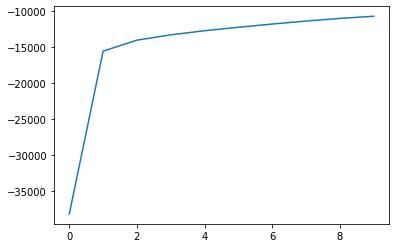

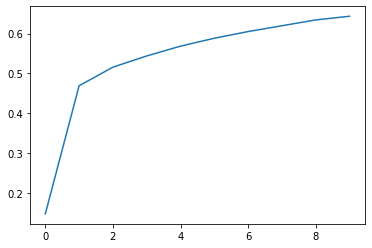

In [19]:
M = 15 # hidden layer size
K = len(label_to_index)  # number of classes
np.seterr(divide='ignore', invalid='ignore')

N = len(Y_train)
T = np.zeros((N, K))
for i in range(N):
    T[i, Y_train[i]] = 1

W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)

learning_rate = 1e-5
costs = []
accuracy = []
for epoch in range(1000):
    output, hidden = forward(X_train, W1, b1, W2, b2)
    if epoch % 100 == 0:
        c = cost(T, output)
        P = np.argmax(output, axis=1)
        r = classification_rate(Y_train, P)
        print("cost:", c, "classification_rate:", r)
        costs.append(c)
        accuracy.append(r)
        print(epoch)
  
    W2 += learning_rate * derivative_w2(hidden, T, output)
    b2 += learning_rate * derivative_b2(T, output)
    W1 += learning_rate * derivative_w1(X_train, hidden, T, output, W2)
    b1 += learning_rate * derivative_b1(T, output, W2, hidden)

plt.plot(costs)
plt.show()
plt.plot(accuracy)
plt.show()

In [20]:
Y_predict,_ = forward(X_test, W1, b1, W2, b2)
N = len(Y_test)
T = np.zeros((N, K))
for i in range(N):
    T[i, Y_test[i]] = 1
c = cost(T, Y_predict)
P = np.argmax(output, axis=1)
r = classification_rate(Y_test, P)
print("cost:", c, "classification_rate:", r)

cost: -2680.039170445906 classification_rate: 0.38037809647979137


predicted: soybean actual: grass


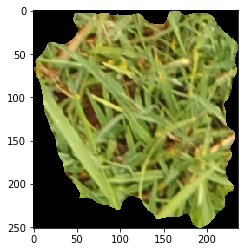

In [21]:
pp = index_to_label[np.argmax(Y_predict[len(Y_predict)-1])]
aa = index_to_label[Y_test[len(Y_test)-1]]
print("predicted:", pp, "actual:", aa)
im = np.array(Image.open(images[len(images)-1]))
plt.imshow(im)
plt.show()

predicted: soybean actual: soybean


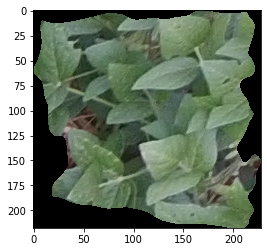

In [23]:
pp = index_to_label[np.argmax(Y_predict[len(Y_predict)-2])]
aa = index_to_label[Y_test[len(Y_test)-2]]
print("predicted:", pp, "actual:", aa)
im = np.array(Image.open(images[len(images)-2]))
plt.imshow(im)
plt.show()